In [1]:
#Importowanie bibliotek
import numpy as np
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from pylab import rcParams
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model,Model
from tensorflow.keras.layers import Input,Dense, Flatten,GlobalAveragePooling2D,Conv2D, BatchNormalization,AveragePooling2D,ZeroPadding2D,LeakyReLU,Dropout
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import EfficientNetB0
from keras.preprocessing.image import img_to_array
from tensorflow.keras import mixed_precision
%matplotlib inline
rcParams['figure.figsize']=22,10

In [2]:
#Inicjalizacja akceleratora GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
#Korzystanie z połowicznej precyzji, która przyśpiesza proces trenowania sieci zachowując tą samą skuteczność co przy 
#pojedynczej precyzji
policy=mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070, compute capability 8.6


Wczytanie zbioru danych do treniungu oraz testu, razem z podstawową augmentacją danych by wzbogacić zbiór danych.

In [4]:
train_gen=ImageDataGenerator(shear_range = 0.2,
                             zoom_range = 0.2,
                             horizontal_flip = True)
test_gen=ImageDataGenerator()

In [29]:
train=train_gen.flow_from_directory('C:/Users/komej/Desktop/birds recognition/v3/train/',target_size=(224,224),batch_size=32,
                                   class_mode='categorical')
test_data=test_gen.flow_from_directory('C:/Users/komej/Desktop/birds recognition/v3/test/',target_size=(224,224),batch_size=1,
                                   class_mode='categorical',shuffle=False)
valid=test_gen.flow_from_directory('C:/Users/komej/Desktop/birds recognition/v3/valid/',target_size=(224,224),batch_size=32,
                                   class_mode='categorical',shuffle=False)

Found 58388 images belonging to 400 classes.
Found 2000 images belonging to 400 classes.
Found 2000 images belonging to 400 classes.


In [7]:
df.head()

,filepaths,labels,data set
0,train/AFRICAN CROWNED CRANE/001.jpg,AFRICAN CROWNED CRANE,train
1,train/AFRICAN CROWNED CRANE/002.jpg,AFRICAN CROWNED CRANE,train
2,train/AFRICAN CROWNED CRANE/003.jpg,AFRICAN CROWNED CRANE,train
3,train/AFRICAN CROWNED CRANE/004.jpg,AFRICAN CROWNED CRANE,train
4,train/AFRICAN CROWNED CRANE/005.jpg,AFRICAN CROWNED CRANE,train


Sieć użyta do tego celu to bardzo wydajna oraz skuteczna EfficientNetB0 przetrenowana na milionach zdjęć, co znacząco ułatwia trenowanie i zwiększa precyzję sieci. 

In [8]:
effnet=EfficientNetB0(include_top=False,weights='imagenet', input_shape=(224,224,3))
for layers in effnet.layers[15:]:
    layers.trainable=False
    
inp=effnet.output
#x=Flatten()(inp)
x=GlobalAveragePooling2D()(inp)
#x=Dense(1024,activation='relu')(x)
#x=Dropout(0.15)(x)
x=Dense(400,activation='softmax')(x)

model=Model(effnet.input,x)

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']      

 block2a_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2b_expand_activation (Act  (None, 56, 56, 144)  0          ['block2b_expand_bn[0][0]']      
 ivation)                                                                                         
          

                                                                                                  
 block3b_expand_activation (Act  (None, 28, 28, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_bn (BatchNormalization  (None, 28, 28, 240)  960        ['block3b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3b_a

 block4b_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 14, 14, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4b_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block4b_se_squeeze[0][0]']     
          

                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block5a_se_reduce[0][0]']      
                                                                                                  
 block5a_s

 block5c_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_drop (Dropout)         (None, 14, 14, 112)  0           ['block5c_project_bn[0][0]']     
                                                                                                  
 block5c_a

                                                                                                  
 block6b_drop (Dropout)         (None, 7, 7, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 7, 7, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6b_add[0][0]']            
                                                                                                  
 block6c_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block6c_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 7, 7, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block7a_dwconv (DepthwiseConv2  (None, 7, 7, 1152)  10368       ['block7a_expand_activation[0][0]
 D)       

Model jest najpierw trenowany z częściowo zamrożonymi warstwami, do 15 wrastwy.

In [7]:
loss=tf.keras.losses.CategoricalCrossentropy()

In [8]:
model.compile(loss=loss,optimizer=Adam(learning_rate=0.0001),metrics=['accuracy'])

In [12]:
history=model.fit(train,epochs=3,validation_data=valid)

Epoch 1/3
1825/1825 [==============================] - 441s 237ms/step - loss: 3.9902 - accuracy: 0.4851 - val_loss: 2.2739 - val_accuracy: 0.8445
Epoch 2/3
1825/1825 [==============================] - 390s 214ms/step - loss: 1.7654 - accuracy: 0.8261 - val_loss: 1.0309 - val_accuracy: 0.9360
Epoch 3/3
1825/1825 [==============================] - 397s 218ms/step - loss: 1.0272 - accuracy: 0.8807 - val_loss: 0.6013 - val_accuracy: 0.9575


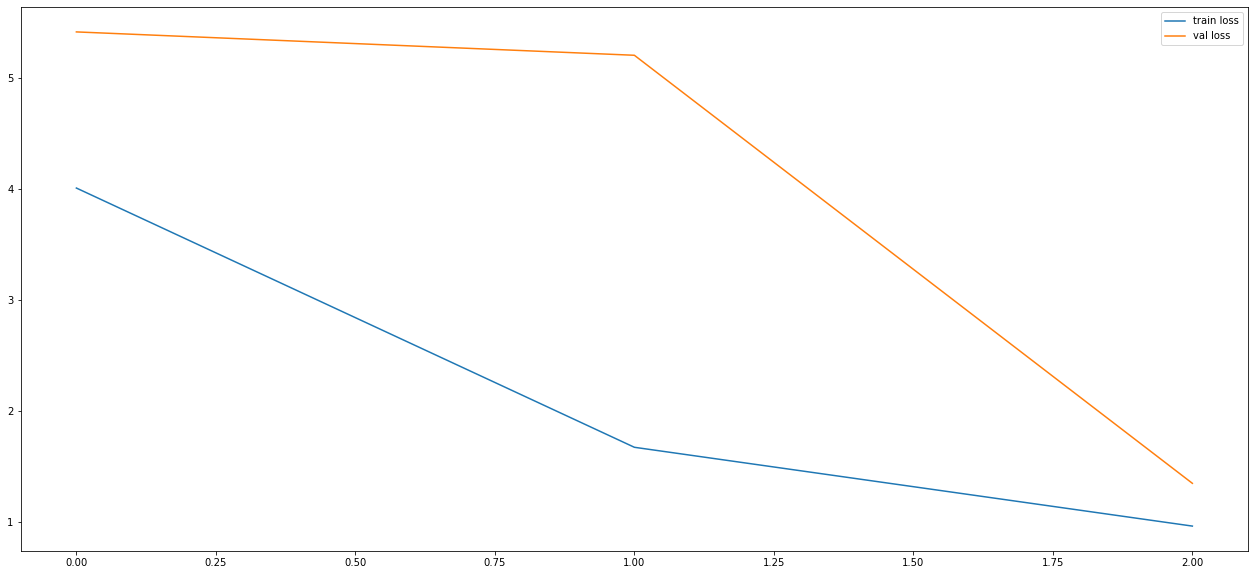

In [24]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

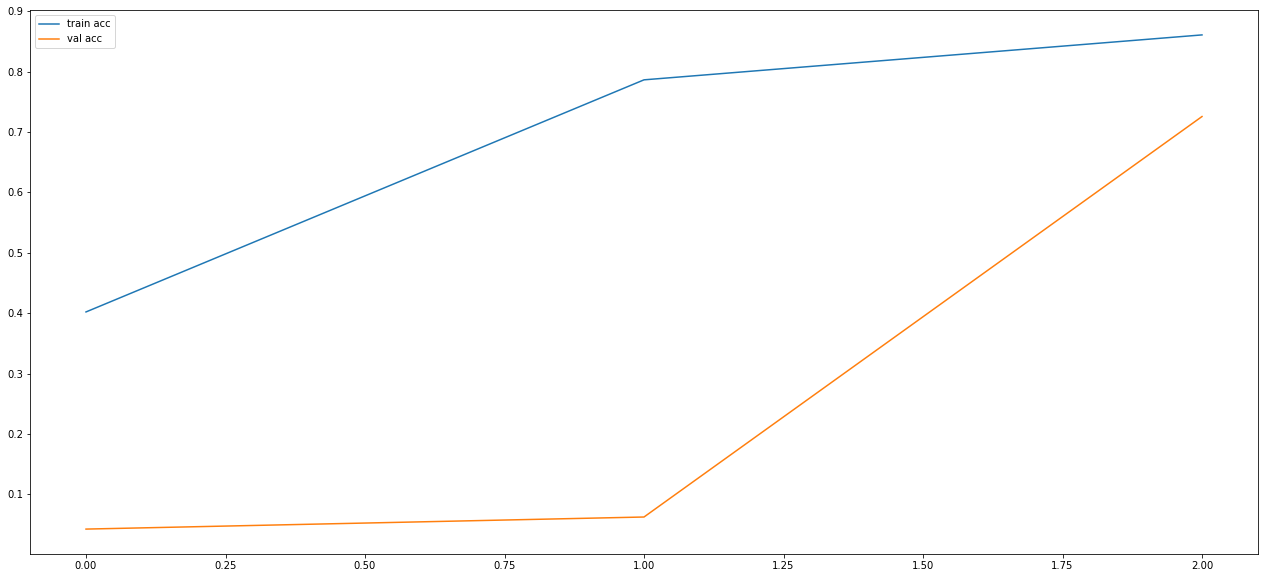

In [25]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

Po kilku iteracjach wszystkie warstwy są odmrażane i model jest trenowawany w całości.

In [12]:
#Funckja do stopniowego odmrażania warstw w celu trenowania poszczególnych warstw.
def unfreeze_model(model):
    for layer in model.layers[15:50]:
        #if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True
    loss=tf.keras.losses.CategoricalCrossentropy()
    model.compile(loss=loss,optimizer=opt,metrics=['accuracy'])

unfreeze_model(model)

In [10]:
model.trainable=True

In [11]:
history=model.fit(train,epochs=5,validation_data=valid)

Epoch 1/5
1825/1825 [==============================] - 448s 240ms/step - loss: 0.7088 - accuracy: 0.9036 - val_loss: 0.4339 - val_accuracy: 0.9520
Epoch 2/5
1825/1825 [==============================] - 390s 213ms/step - loss: 0.5421 - accuracy: 0.9203 - val_loss: 0.3306 - val_accuracy: 0.9600
Epoch 3/5
1825/1825 [==============================] - 396s 217ms/step - loss: 0.4468 - accuracy: 0.9300 - val_loss: 0.2680 - val_accuracy: 0.9630
Epoch 4/5
1825/1825 [==============================] - 396s 217ms/step - loss: 0.3803 - accuracy: 0.9379 - val_loss: 0.2284 - val_accuracy: 0.9670
Epoch 5/5
1825/1825 [==============================] - 387s 212ms/step - loss: 0.3340 - accuracy: 0.9441 - val_loss: 0.1994 - val_accuracy: 0.9690


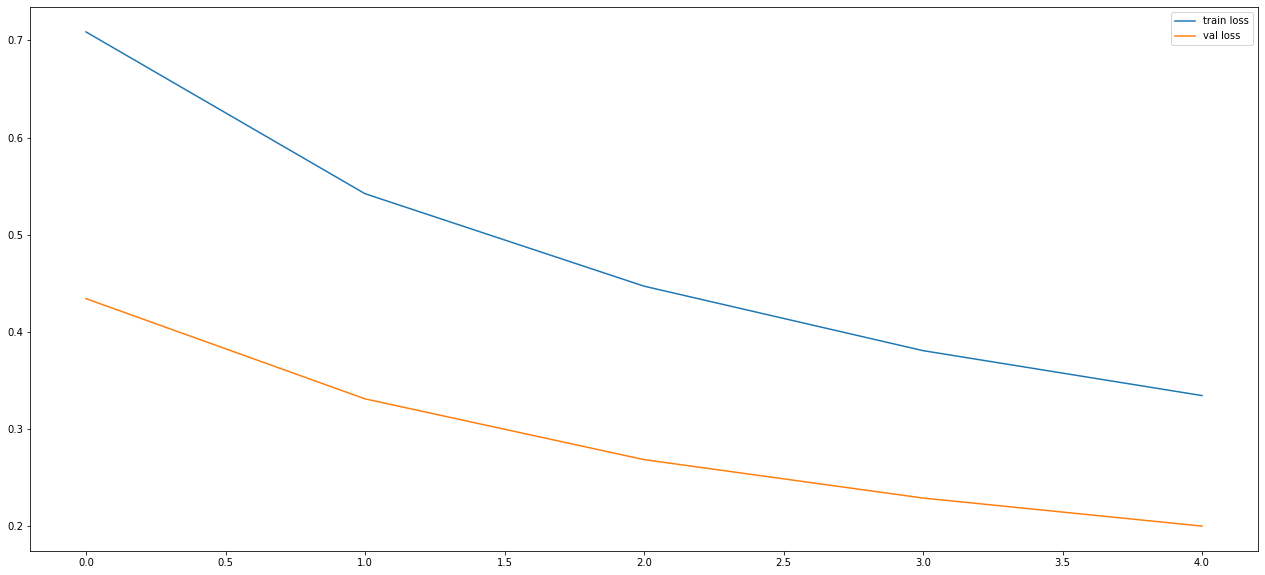

In [12]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

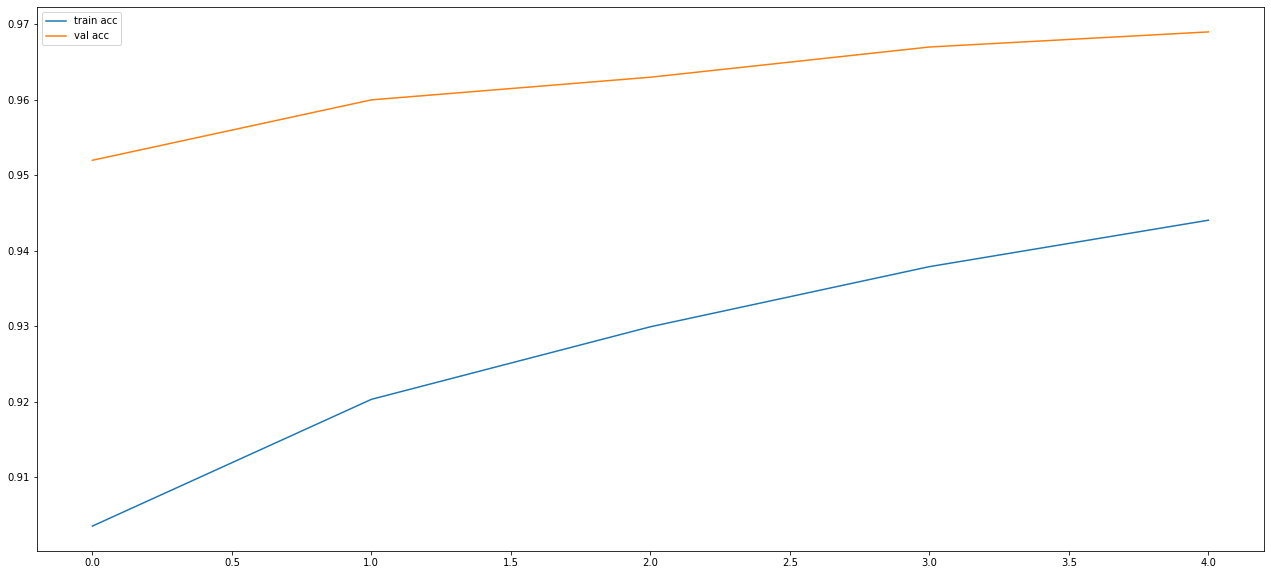

In [13]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

Wyniki trenowania sieci są satyfakcjonujące. Dokładność na zbiorze treningowym wynosi prawie 95%, a na zbiorze walidacyjnym aż 97%, porównania graficzne w innym pliku.

In [30]:
score_eval=model.evaluate(test_data)

2000/2000 [==============================] - 143s 71ms/step - loss: 0.0414 - accuracy: 0.9935


In [49]:
score_predict=model.predict(test_data)

In [62]:
for v in range(len(score_predict)):
    ind=np.argmax(score_predict[v])
    score_predict[v,ind]=1
score_predict=np.round(score_predict)

In [72]:
true_labels=[]
for l in range(len(test_data)):
    true_labels.append(test_data[l][1])
true_labels=np.array(true_labels)[:,0,:]
true_labels=np.float16(true_labels)

In [84]:
df=pd.read_csv('C:/Users/komej/Desktop/birds recognition/v3/class_dict.csv')
report=metrics.classification_report(true_labels,score_predict,target_names=df['class'],zero_division=1)

In [85]:
print(report)

                             precision    recall  f1-score   support

            ABBOTTS BABBLER       1.00      1.00      1.00         5
              ABBOTTS BOOBY       1.00      1.00      1.00         5
 ABYSSINIAN GROUND HORNBILL       1.00      1.00      1.00         5
      AFRICAN CROWNED CRANE       1.00      1.00      1.00         5
     AFRICAN EMERALD CUCKOO       1.00      1.00      1.00         5
          AFRICAN FIREFINCH       1.00      1.00      1.00         5
     AFRICAN OYSTER CATCHER       1.00      1.00      1.00         5
                  ALBATROSS       1.00      1.00      1.00         5
             ALBERTS TOWHEE       1.00      1.00      1.00         5
       ALEXANDRINE PARAKEET       1.00      1.00      1.00         5
              ALPINE CHOUGH       1.00      1.00      1.00         5
      ALTAMIRA YELLOWTHROAT       1.00      1.00      1.00         5
            AMERICAN AVOCET       1.00      1.00      1.00         5
           AMERICAN BITTERN      

Tak jak widać na raporcie precyzja, czułość oraz f-score osiągają bardzo dobre wyniki na większości gatunków ptaków, które są w zbiorze testowym.

In [42]:
model.save('C:/Users/komej/Desktop/birds recognition/v3/bird4v2.h5')